## 1 Preprocessing

**(a) First we will load the data using spark data source API. Write codes to load and print out its schema using printSchema().**

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
import matplotlib.pyplot as plt
import pandas as pd
ss = SparkSession.builder.appName("Python Spark").getOrCreate()
df = ss.read.format('csv').options(header='true').load('train.csv')
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



**(b) Find columns that include Missing values. After that, fill the mean value for all the missing values. Please drop Ticket and Cabin columns and do not modify categorical variables
like Embarked.**

In [3]:
df = df.drop(*['Ticket', 'Cabin'])
df.select(*(functions.sum(functions.col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+-----------+--------+------+----+---+---+-----+-----+----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Fare|Embarked|
+-----------+--------+------+----+---+---+-----+-----+----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|   0|       2|
+-----------+--------+------+----+---+---+-----+-----+----+--------+



Only 'Age' column has missing values, except 'Embarked'

In [4]:
avg_age = df.select('Age').describe().collect()[1]['Age']
df = df.fillna({'Age':avg_age})

**(c) Visualize a histogram for an Age column.**

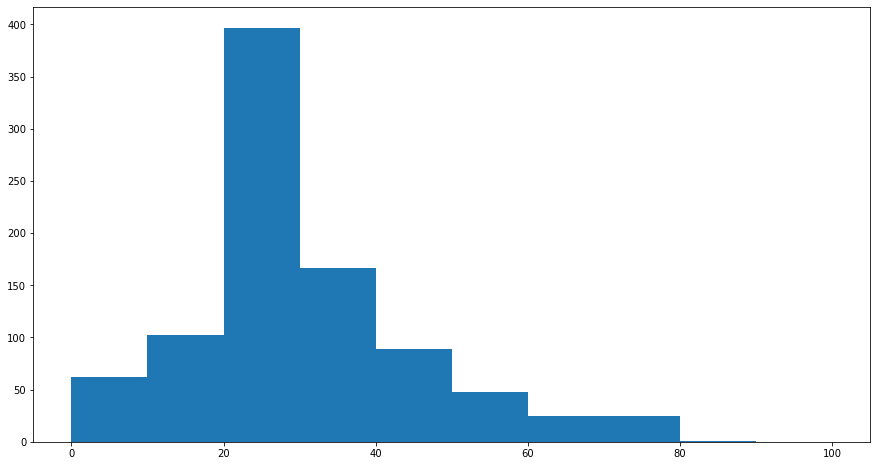

In [5]:
age = df.select('Age').toPandas()['Age'].tolist()
age = [float(a) for a in age]
age.sort()
plt.rcParams["figure.figsize"] = (15,8)
plt.hist(age, bins=[0, 10, 20, 30, 40, 50, 60, 80, 90, 100])
plt.show()

**(d) Many columns are categorical variables. So we use one-hot encoding using spark ML pipeline API. In this example, we are using StringIndexer and OneHotEncoder to do that. For
missing values or NaN values, please replace them as \0", which has a String type.**

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
categories = ['Survived', 'Pclass', 'Sex', 'Embarked']
append_list = []
df = df.fillna({'Embarked': '0'}) ### fill NaN values to '0'

for ctg in categories:
    indexer = StringIndexer(inputCol = ctg, outputCol = f'{ctg}Index')
    encoder = OneHotEncoder(inputCol = f'{ctg}Index', outputCol = f'{ctg}Vec')
    append_list.append(indexer)
    append_list.append(encoder)
    
va = VectorAssembler(inputCols=['PclassVec', 'SexVec', 'EmbarkedVec'], outputCol='features')
append_list.append(va)

pipeline = Pipeline(stages = append_list)
myDf = pipeline.fit(df).transform(df)

**(e) One we prepared our data, we split the data into two sets: training (80 %) and testing (20 %) datasets. We use Spark’s randomSplit method to get them. Please leave the code.**

In [8]:
train_set, test_set = myDf.randomSplit([0.8, 0.2])

## 2 Classification using Logistic Regression
**In this questions below, you will train and test a logistic regression model. Please leave your codes for each part in your report**

**(a) Create stages for all features, which are processed above, and make a pipeline with logistic regression using default parameters.**

In [9]:
from pyspark.ml.classification import LogisticRegression

logi = LogisticRegression(featuresCol='features', labelCol = 'SurvivedIndex')
m_pipeline = Pipeline(stages = [logi])

**(b) Fit the model.**

In [10]:
model = m_pipeline.fit(train_set)

**(c) Once model is trained, we need to know how it’s performing. So we use precision score as our evaluation metric. Report the result. You can refer to RDD-Evaluation or Precision
with Micro option (Scikit-learn).**

In [11]:
from sklearn.metrics import precision_score ###Using Scikit-learn
actual = test_set.toPandas()['SurvivedIndex'].tolist()
predict = model.transform(test_set).toPandas()['prediction'].tolist()
score = precision_score(actual, predict,average='micro')
print("Precision Score :", score)

Precision Score : 0.7660818713450293


**(d) From the fitted model, please identify which attribute is contributed the most? (Hint: Print the coefficients and intercepts for logistic regression.)**

In [12]:
print("Coefficients :")
for num in model.stages[0].coefficients:
    print(num)
    
print("\nIntercept: " + str(model.stages[0].intercept))

Coefficients :
-1.3122070569307738
0.7653343085213908
-2.537477135965413
1.1505668062912542
1.7825369869421497
1.8090633428878429

Intercept: 0.14672616717563702


'Embarked' attributed most